<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - EDA & Cleaning

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline

# Set option to see the full string
pd.set_option('display.max_colwidth', 1000)


## Import Data

In [2]:
# Import webscraped CSV files
xbox_posts = pd.read_csv('./datasets/xbox.csv')
playstation_posts = pd.read_csv('./datasets/playstation.csv')


## Combine subreddit posts

The text in the subreddit posts are a rich source of information, but as its unstructured information, extracting insights can be challenging. As such we'll be doing text classification using NLP and Machine Learning Models. We are interested to explore the below variables
* **author**
    * This will help us check posts from moderators or bots that could be irrelevant to our dataset
* **title & selftext**
    * These contain all the user generated texts, and represents the features essential for our modelling. 
* **subreddit**
    * These tells us the actual subreddit for the given posts
    


In [3]:
# Create dataframes with selected columns of interest
xbox_posts = xbox_posts[['author','title','selftext','subreddit']]
playstation_posts = playstation_posts[['author','title','selftext','subreddit']]

# Concatenate both xbox and playstation dataframes
posts = pd.concat(
    [xbox_posts, playstation_posts],
    axis=0
)

# Combine the selftext and title columns
posts['text'] = posts['title'] + ' ' + posts['selftext']

# Covert text to lowercase
#posts['text'] = posts['text'].str.lower()

# Drop the title and selftext columns
posts = posts.drop(
    columns = ['title', 'selftext'],
    axis = 1
)

In [4]:
posts.head()

,author,subreddit,text
0,Help_PurpleVented,xbox,Custom status? Saw this dude playing mw change his game to gta 6 whenever he wanted anyone know how he did that?
1,dredgesledge,xbox,Are You Still Able To Buy DOOM XBLA Edition? I wanna buy it for its online co-op and deathmatch (its most likely dead but I have a friend I can do co-op with). I tried to buy it off of Microsoft's website but all I could do was get the Demo. I than tried to buy it on my Xbox 360 from the Demo but it didn't let me. All I can do is play the demo which doesn't have online.
2,Lizlucila,xbox,Image download How do I download an image from Microsoft edge with the new update??? I could do it perfectly fine last month with the normal way but with the new update I can’t anymore… please help
3,Lizlucila,xbox,PLEASE HELP [removed]
4,MichaelEastV,xbox,NaN


#### Number of posts (After Webscraping)

In [5]:
print(posts['subreddit'].value_counts())
print(posts['subreddit'].value_counts(normalize=True))

xbox           2200
playstation    2200
Name: subreddit, dtype: int64
xbox           0.5
playstation    0.5
Name: subreddit, dtype: float64


## Clean Data

### Check for missing values

In [6]:
# Check for missing values in dataframe
print(f'{posts.isnull().sum()}\n')

# Check for missing values in 'text'
posts = posts.dropna()

# Check number of posts after dropping
print(posts['subreddit'].value_counts())

author          0
subreddit       0
text         1606
dtype: int64

xbox           1410
playstation    1384
Name: subreddit, dtype: int64


* 790 xbox & 816 playstation posts had missing text and were removed. Its possible that some of these posts only had pictures embedded, or the post is empty as the user may have deleted their account. We wouldn't know for sure exactly, but its not important for us

### Check for duplicates

In [7]:
# Check for duplicate rows
print(posts[posts.duplicated()][:3])

# Remove duplicated rows except for first occurence
posts = posts.drop_duplicates(
    keep = 'first'
)

                 author subreddit  \
427  doyouknowthewaymen      xbox   
467           [deleted]      xbox   
789             Vipinhp      xbox   

                                                                                                                                                                                                                                                                                                    text  
427  Xbox muliplayer problems Hello there. Yesterday I bought xbox game pass for pc, and I downloaded Sea of Thieves. Now I wanted to play with friend but I can't, it popped up a message that I can't play muliplayer games, I went to xbox.com and tried to fix it, but it didn't work. What do I do?  
467                                                                                                                                                                                                                                             It really tie

* 3 xbox post by the same author were duplicated and removed

In [8]:
# Check for duplicated text
print(posts[posts.duplicated(
    subset = 'text')
])

# Remove duplicated text except for first occurence
posts = posts.drop_duplicates(
    subset = 'text',
    keep = 'first'
)

# Reset Index
posts = posts.reset_index()
posts = posts.drop(columns='index',axis=1)

                   author    subreddit                             text
151             javin2323         xbox            Help please [removed]
700               DHJ-888         xbox               Question [removed]
718          illstylez420         xbox              Need help [removed]
983           BlueAngelVR         xbox                   Help [removed]
1082     Gold-Singer-3530         xbox            I need help [removed]
1294       UncreativeMilk         xbox               Question [removed]
1317        ThatsAYikes06         xbox                   Help [removed]
1467    IndividualBid4115         xbox            I need help [removed]
1537              Russ435         xbox            please help [removed]
1611    EpicDCMusicVideos         xbox               Question [removed]
1680              slammfd         xbox               Question [removed]
1820        dieofcringe42         xbox            I need help [removed]
1999     Fun_Traffic_6991         xbox                   Help [r

* Most of the duplicated text are due to posts being removed by the moderator. I still want to keep the first instances, but will deal with the [removed] word when doing eda on words.

### EDA on Text

Although we can perform text preprocessing using tokenizers, there is some freedom to manually cleaning the data first. 

In [9]:
# Display 3 rows of posts with newline
posts.loc[posts['text'].str.contains(r'\n', regex=True),'text'][:3]

11                                                                                                                                               Is it possible to transfer a gamertag to a different Microsoft account? Hey guys. \n\nSo, long story short, I've got a Microsoft account attached to an email that has been leaked multiple times over the years. Right now, I keep being spammed all the time and Microsoft's spam filter is unable to catch the harmful emails. It is extremely frustrating. I want to close said email account completely but I am worried about my Xbox account. Is it possible to somehow transfer it to another Microsoft account? Or use a different email to login? I don't want to lose my games and achievements. :(\n\nAny ideas? :(
15                                                                                                                                                                                                                                                     

* \n\n denotes a new line. There is not spacing between it and the adjacent words. When removing, will need to put a space between

In [10]:
# Display 3 rows of posts with character code for a zero-width space
posts.loc[posts['text'].str.contains(r'&amp;#x200B', regex=True),'text'][:3]

24                                Can't sign in? (360) I've been logged out of Live on my 360 for a bit since i changed my password, but tried to sign back in to buy some DLC. I keep getting the message that my email or password is wrong, even though I can sign in fine on my laptop. I tried changing the password again, setting up 2-step authentication on my phone, deleting the profile on my 360, all of the basic stuff Google tells you. Keep getting the same message.\n\n&amp;#x200B;\n\nHow can I get my profile back? I'm especially upset about this now since I can't download my profile back and get my saves and stuff back :/
35                                                                                                                                                                                         Is there a way to link games that are on Steam with Xbox Achievements? For Example, I have Fable Anniversary on Steam (and other games that are on both PC and XBOX), is there a way t

* &amp;#x200B denotes the character code for a zero-width space, which is usually between two new lines (\n\n), but we won't assume its consistently always between the new lines, hence we will remove them seperately from the new lines

In [11]:
# Display 3 rows of posts with asterisks
posts.loc[posts['text'].str.contains(r'\*', regex=True),'text'][:3]

66     For some reason, Xbox Gamepass Never Expired on my Xbox, What should I do  \n\n***Disclaimer***\n\n***I didn't mean to exploit or hack my Xbox one in Any way It just seemed to be an Error***\n\n***and I'm wondering what I should do, I do not support hacking or modding the Xbox 1 and this is in no way A tutorial***\n\nSo about a year and a half ago, I bought an Xbox one and It came with an Xbox game pass and Live Trail for a Week or two, (at the Time I didnt have wifi at my home and was staying at a Freinds when I Started the trail) I downloaded about ten games using gamepass and then went back home and for some reason even after the week or two that gamepass was "meant to last" its still there and Because I didnt have Wifi until Somewhat recently it stayed like that for more than a year and all the gamepass games still function\n\nI have not updated the Firmware yet or connected to the Wifi because Im worried that Xbox might not have synced my save files for the games and when t

* Asterisks(*) denotes bullet points and bold type face which will be removed

In [12]:
# Display 3 rows of posts with links and hyperlinks
posts.loc[posts['text'].str.contains(r'\[.*?\]\(.*?\)', regex=True),'text'][:3]

52    Xbox one power LED mystery Hey there! I took my xbox one X apart to install a purple power button LED in place of the white one. My partner liked it so much, they asked me to install a red power LED in their original xbox one. \n\nWhen I took their xbox one apart, I discovered an extra, unpopulated pad call D4 that was definitely designed for an LED, right next to the populated D1 LED pad. I can't find any information about this empty pad. I've seen it on youtube and other places online but no one addresses it. Does anyone know what it was supposed to be used for? \n\nI went ahead and installed a blue LED on the unpopulated pad to see if it would do anything, but so far just the red LED is lighting up on my partner's xbox one. Any info about this is greatly appreciated!\n\n[pics for reference ](http://imgur.com/gallery/b1LyLkT)
81                                                                                                                                                        

* Hyperlink and links denoted by the text between the []\(\) brackets parentheses. We will remove all links and hyperlinks

In [13]:
# Display 3 rows of posts with subreddit names
searchfor = ['xbox','playstation','ps']
posts.loc[posts['text'].str.contains('|'.join(searchfor)),'text'][:3]

5    Does the gold to xbox live ultimate conversion still work? Planning on purchasing two years of xbox live gold next week and want to double check with you guys if the conversion to xbox  ultimate game-pass still works? I'm new to Xbox as I just purchased a series S so I plan on using the 3 months of ultimate for a dollar as my conversation method. Hopefully I'll be good. I'm very nervous!
8                      Monitor speaker broken? Audio keeps coming through the speaker on my monitor and I can't change the speaker audio off stereo uncompressed without a pop up saying I need to choose at least one audio setting as both cannot be turned off. Ive also made sure to mute the monitor and it's done nothing. I'm really confused on what to turn on or do so help would be appreciated.
9                                                                                                                                                                                          Do xbox game pass for

* We will remove the subreddit name and ps (xbox, playstation, ps)

In [14]:
# Display 3 rows of posts with numbers
posts.loc[posts['text'].str.contains(r'\b\d+\b', regex=True),'text'][:3]

0                                                                                                                                                                                                                                                                                          Custom status? Saw this dude playing mw change his game to gta 6 whenever he wanted anyone know how he did that?
1                      Are You Still Able To Buy DOOM XBLA Edition? I wanna buy it for its online co-op and deathmatch (its most likely dead but I have a friend I can do co-op with). I tried to buy it off of Microsoft's website but all I could do was get the Demo. I than tried to buy it on my Xbox 360 from the Demo but it didn't let me. All I can do is play the demo which doesn't have online.
5    Does the gold to xbox live ultimate conversion still work? Planning on purchasing two years of xbox live gold next week and want to double check with you guys if the conversion to xbox  ultimate game-pas

* numbers are denoted by digits from 0-9, we will remove them before removing punctuations

In [15]:
# Display 3 rows of posts with punctuations
posts.loc[posts['text'].str.contains(r'[\.\(\),\^\[\]\!\?\@\'\`\"\_\n]', regex=True),'text'][:3]

0                                                                                                                                                                                                                                                                        Custom status? Saw this dude playing mw change his game to gta 6 whenever he wanted anyone know how he did that?
1    Are You Still Able To Buy DOOM XBLA Edition? I wanna buy it for its online co-op and deathmatch (its most likely dead but I have a friend I can do co-op with). I tried to buy it off of Microsoft's website but all I could do was get the Demo. I than tried to buy it on my Xbox 360 from the Demo but it didn't let me. All I can do is play the demo which doesn't have online.
2                                                                                                                                                                                   Image download How do I download an image from Microsoft edge wi

* Punctuations are denoted by symbols. We will use regex to remove all symbols finally.

In [16]:
def regex(row):
    
    # Lowercase the string without splitting
    row = row.lower()
    
    # Remove Newlines
    row = re.sub(r'\n+', ' ', row)
    
    # Remove Quotes
    row = re.sub(r'\"?\\?&?gt;?', '', row)
    
    # Remove Bullet Points
    row = re.sub(r'\*', '', row)
    
    #Remove character code for zero-width space
    row = re.sub('&amp;#x200b;', '', row)
    
    # Remove Links & Hyperlinks []()
    row = re.sub(r'\[.*?\]\(.*?\)', '', row)
    
    # Remove [deleted] & [removed]
    row = re.sub(r'\[.*?\]', '', row)
        
    # Remove Websites
    row = re.sub(r'http\S+', '', row)
    
    # Remove subreddit titles
    row = row.replace('playstation','')
    row = row.replace('xbox','')
    row = row.replace('ps','')
    
    # Remove digits
    row = re.sub(r'\b\d+\b', '', row)
    
    # Remove puctuations
    row = re.sub(r'[\.\(\),\^\[\]\!\?\@\'\`\"\_\n]', ' ', row)
    
    
    return row

posts['text'] = posts['text'].apply(regex)

#### Number of posts (After Cleaning)

In [17]:
print(posts['subreddit'].value_counts())
print(posts['subreddit'].value_counts(normalize=True))

xbox           1388
playstation    1367
Name: subreddit, dtype: int64
xbox           0.503811
playstation    0.496189
Name: subreddit, dtype: float64


## EDA on word count

Before vectorizing the text, we will look at the length and the word count for each reddit submission

In [18]:
# Create a new column called `text_length` that contains the length of each status
posts['text_length'] = posts['text'].map(lambda x: len(str(x)))

# Create a new column called `status_word_count` that contains the number of words in each status
posts['text_word_count'] = posts['text'].map(lambda x: len(str(x).split(' ')))

In [19]:
# top 20 shortest text_word_count
posts.sort_values(by = 'text_word_count',ascending=True)[:20]

,author,subreddit,text,text_length,text_word_count
1433,xLouisxCypher,playstation,,0,1
2652,AromaticCity4026,playstation,,0,1
1803,coolwali,playstation,,0,1
82,Bakedham51,xbox,question,9,2
317,Imblu236,xbox,pls,4,2
1536,CHTHAGOAT04,playstation,suspension,11,2
1028,connor_diddy,xbox,,1,2
2640,Weekly_Ad1205,playstation,headphones,11,2
988,kungendani,xbox,help,5,2
683,Ok_Visit3803,xbox,enforcement,12,2


**Observations**
* Some posts have missing text, which can be explained by the manual cleaning done earlier
* Most posts with text_word_counts less than 20 were mostly authors asking for help or displayed error messages 

In [20]:
# top 10 longest text_word_count
posts.sort_values(by = 'text_word_count',ascending=False)[:10]

,author,subreddit,text,text_length,text_word_count
1183,Successful_Gold9307,xbox,ambassadors so what s the story behind ambassadors on the support forums on every single thread posted since the beginning of time there are a pile of these peoplebots that reply asap to any question or complaint with; •did you hard reset your here s how to do it the link to the page that explains the process these helpful creatures are so eager to please the jepettos in corporate office that they all answer with the same cookie cutter responses in succession on the same post on every post ever made they all have the title ambassador and they rarely ever answer the question or solve the problem so who are these so called ambassadors and when will the actual support staff be present in the community to field questions and solve problems tbh i have never seen one solved on support forums unless another normal and decent human being like the one who originally posts the topic answers it why are the people at so adamant on ignoring their ...,6404,1404
1160,Successful_Gold9307,xbox,thank you to everyone announcement you can consider yourselves the reason people like me don t want to help anymore i took down my last post i posted it with the intention to stick up for people like y all and myself who have been shafted pretty hard by the products that we pay for and the issues they have that are never actually fixed the problems that are never solved and the blatant disrespect and lack of effort given by the entity as a whole it s unethical and i m definitely in the majority with how i feel we ve been treated and so many millions of people have said similar things yet i find one common denominator that happens everytime someone brings up any type of real issue for some reason if there is ever something to complain about and someone says anything in defense of themselves and others which technically should be appreciated there is always the people who reply to said post or have something to say about the real factual issues that you just spo...,4176,871
2438,BrBronco,playstation,sony s low effort hubris and the errors of timed exclusivity let me start by saying that sony has made some of my favorite games recently god of war bloodborne tlou1&amp; and many others and i think they ve been killing when it comes to first party since the days i also think that they did an excelente job designing the and it offers great value for a $ machine seems like every one of their bets paid of with that said their value proposition is starting to look pretty bad in comparison to what is out there seems like sony is set on shameless nickel-and-diming their user base they spear-headed the new $ new game price and they also are committed to charging an extra $ for version of games right now sony has about 125m+ consoles out there and they have 45m+ plus subscriptions at $ a year charging for something that if we are being honest should be free as it always was on pc for any storefront and for any game regardless of size with all that money coming ...,3825,788
2397,zondie7,playstation,i m so glad has backwards compatabiliy i made a huge error choosing one over the i bought the one s late into the generation because i was thinking that would be a stockpile of games waiting for me but i was wrong i ve literally run out of games i find interesting on the microsoft store single-player offline games that are non-shooters fromsoftware games mainly i m glad i had gamepass so that i could try all the games that i thought maybe i would get interested in without paying for them i have to switch i think is too focused on shooters and i don t like them i m not hating on but the games on it just aren t my type of game the console is also more focused on the online gaming aspects than and when i do play online just fifa and tekken the players are less than players games i ve finished with my opinions on them: dark souls about time all ng since ng+ is not well done- great game with great lo

**Observations**
* The longest texts consists of alot of information useful to our model. Hence, we will retain these posts
* As compared to the shortest text, the longest text still consists of many symbols, punctuations and numbers. We will deal with it later when using the tokenizer

### Distribution of  length and word count

Mean of Length is: 330.891
Mean of Word Count is: 73.276


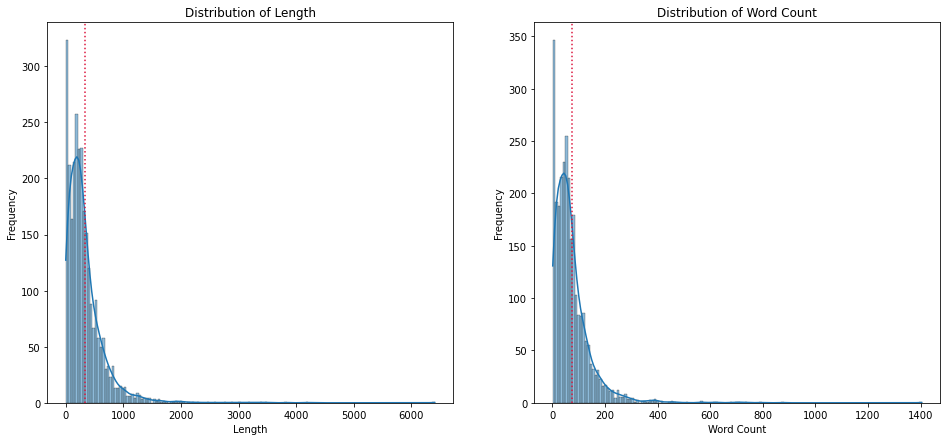

In [21]:
# Plot histogram to see text_word_length and text_word_count
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 7))

sns.histplot(ax=ax1, data=posts, x='text_length', kde=True, )
ax1.axvline(x=posts['text_length'].mean(), color='crimson', ls=':')
ax1.set_title('Distribution of Length')
ax1.set_xlabel('Length')
ax1.set_ylabel('Frequency')

sns.histplot(ax=ax2, data=posts, x='text_word_count', kde=True)
ax2.axvline(x=posts['text_word_count'].mean(), color='crimson', ls=':')
ax2.set_title('Distribution of Word Count')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency');

print(f'Mean of Length is: {round(posts["text_length"].mean(),3)}')
print(f'Mean of Word Count is: {round(posts["text_word_count"].mean(),3)}')

**Observations**
* An average length is 335 and average word count is 73 (inclusive of both Title & selftext)
* The distributions between length & word count are similar, which is what we want to observe. If there were abnormality, we will want to further inspect indivdual words for links/words without spacings etc.

### Remove posts with 20 or less word counts

As these posts, majority of them are not related to the subreddit as they are asking for help and dealing with error codes, we will remove them

In [22]:
# Create new dataframe with posts with more than 20 word counts
posts = posts.loc[posts['text_word_count'] > 20,]


#### Number of posts (After removing post with 20 or less word counts)

In [23]:
print(posts['subreddit'].value_counts())
print(posts['subreddit'].value_counts(normalize=True))

xbox           1195
playstation    1006
Name: subreddit, dtype: int64
xbox           0.542935
playstation    0.457065
Name: subreddit, dtype: float64


## EDA on Author

Would like to explore and analyze the Authors and see what the total number of posts per author represents.

In [24]:
# Unique authors in reddit post
print(f'There are {len(posts["author"].unique())} authors between the 2 subreddits')

There are 2010 authors between the 2 subreddits


In [25]:
# Top 10 Authors
posts['author'].value_counts(ascending=False)[:10]

SirRoderic         17
Silver_Writing      6
DREAMINGMASTR       6
Chuckhalo2099       5
PlaneDot            4
[deleted]           4
Silly-Tale-6311     4
NB_Leo              4
CactusRad           3
fomo117             3
Name: author, dtype: int64

In [26]:
# Check Author with most unique posts
posts.loc[posts['author'] == 'SirRoderic',:]

,author,subreddit,text,text_length,text_word_count
1695,SirRoderic,playstation,what should the next game i buy be the witcher skyrim special edition horizon zero dawn or fallout i can only pick one since i won t have enough money to buy another one for at least a month so pick one based in these criteria: replayability how fun the gameplay is how many hours of content it provides difficulty preferably not too hard but also not too easy,371,80
1989,SirRoderic,playstation,is ok to leave the on rest mode overnight i m downloading a game and it will take after midnight to finish but i need to sleep and don t want to just pause the download and start it again at the morning so is it ok to leave the console on rest mode overnight,263,60
2029,SirRoderic,playstation,what is that thing that is left on the controller after sweat on the controller dries and how do i clean it after a while it gets close to impossible to clean,160,34
2051,SirRoderic,playstation,how many times can a dualshock charge before its battery life starts degrading like how many charge cycles it s lithium battery has,134,26
2060,SirRoderic,playstation,i just did a wifi speed test check description for the results and if the results are accurate then why is my which is connected to the same wifi network as the device i did the speed test on downloading games at - mb download speed mb upload speed mb jitter 1ms ping 16ms,283,65
2074,SirRoderic,playstation,so i ordered dark souls for my and it will be here in days in the meantime are there any good free games i could install i ve already installed genshin impact and splitgate,178,40
2203,SirRoderic,playstation,i ve noticed they are using a new disc drive for the how do i safely insert and eject a disk because it s not like old disc drives where a little tray comes out where you can put the disk,192,46
2211,SirRoderic,playstation,i m making this post to ask the remaining questions i have where do i set how long will the stay open before it enters rest mode what is screensaver and what does it do is there a way to make it so once the console entered rest mode and starts charging the controller/s to make it so after its charged fully for the console to shut down automatically i m asking because i would like to put the controller to charge before i sleep and for the console to shut down by it self after charging is complete,516,115
2214,SirRoderic,playstation,i was told that setting it so the controller communicates with the console via the usb cable instead of bluetooth that it would slowly ruin the battery of the controller but how wouldn t it make sense that if the controller is connected to the console via usb that it would use the electricity from the console to power the controller instead of the controller using its battery,382,72
2216,SirRoderic,playstation,how do i make it so the sound instead of my tvs speaker comes out of the headphones i ve connected to the dualshock because my tvs speakers are too loud,156,35


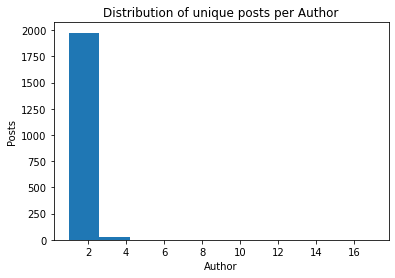

In [27]:
# Distribution of unique posts per author
posts['author'].value_counts().plot(kind='hist')
plt.title('Distribution of unique posts per Author')
plt.xlabel('Author')
plt.ylabel('Posts');

**Observations**
* No moderator or bots observed in the dataset
* As we have removed duplicated posts, there doesn't seem to be anything out of the ordindary. Large number of authors have less than 3 unique posts.
* No action required after doing EDA on the author

## EDA on n-grams

To build our representation of our vocabulary we will use countvectorizer to tokenize, vectorize and represent the corpus in an appropriately.

* Unigram
* Bigram
* Trigram

In [30]:
def text_ngrams(ngrams):
    
    if ngrams == 'unigram':
        name = 'Unigrams'
        ngram_range = (1, 1)
    
    elif ngrams == 'bigram':
        name = 'Bigrams'
        ngram_range = (2, 2)
    
    elif ngrams == 'trigram':
        name = 'Trigrams'
        ngram_range = (3, 3)
        
    # Create individual pandas series text for xbox and playstation
    X_xbox = posts.loc[posts['subreddit'] == 'xbox','text']
    X_playstation = posts.loc[posts['subreddit'] == 'playstation','text']
    
    # Instantiate CountVectorizer without stopwords
    no_stopwords_cvec = CountVectorizer(
        max_features = 1000,
        ngram_range = ngram_range,
    )
    
    
    # Fit & Transform text
    xbox_no_stopwords_cvec = pd.DataFrame(no_stopwords_cvec.fit_transform(X_xbox).todense(),
                          columns = no_stopwords_cvec.get_feature_names())
    
    playstation_no_stopwords_cvec = pd.DataFrame(no_stopwords_cvec.fit_transform(X_playstation).todense(),
                      columns = no_stopwords_cvec.get_feature_names())
    
    # Instantiate CountVectorizer with stopwords
    stopwords_cvec = CountVectorizer(
        max_features = 1000,
        ngram_range = ngram_range,
        stop_words = 'english',
    )
    
    # Fit & Transform text
    xbox_stopwords_cvec = pd.DataFrame(stopwords_cvec.fit_transform(X_xbox).todense(),
                          columns = stopwords_cvec.get_feature_names())
    
    playstation_stopwords_cvec = pd.DataFrame(stopwords_cvec.fit_transform(X_playstation).todense(),
                      columns = stopwords_cvec.get_feature_names())
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (20, 20))
    fig.suptitle(
        t = f'Top 25 {name} in each Subreddit Post',
        size = 45,
        #va = 'baseline',
        weight = 0.3
    )
    
    xbox_no_stopwords_cvec.sum().sort_values(ascending=True).tail(25).plot(kind='barh', ax = ax1)
    ax1.set_title(f'Xbox Posts without Stopwords')
    ax1.set_xlabel(f'Frequency')
    ax1.set_ylabel(f'Words')

    
    playstation_no_stopwords_cvec.sum().sort_values(ascending=True).tail(25).plot(kind='barh', ax = ax2)
    ax2.set_title(f'Playstation Posts without Stopwords')
    ax2.set_xlabel(f'Frequency')
    ax2.set_ylabel(f'Words')
    
    xbox_stopwords_cvec.sum().sort_values(ascending=True).tail(25).plot(kind='barh', color='green', ax = ax3)
    ax3.set_title(f'Xbox Posts with Stopwords')
    ax3.set_xlabel(f'Frequency of words')
    ax3.set_ylabel(f'Words')
    
    playstation_stopwords_cvec.sum().sort_values(ascending=True).tail(25).plot(kind='barh', color='green', ax = ax4)
    ax4.set_title(f'Playstation Posts with Stopwords')
    ax4.set_xlabel(f'Frequency of words')
    ax4.set_ylabel(f'Words')
    
    return 

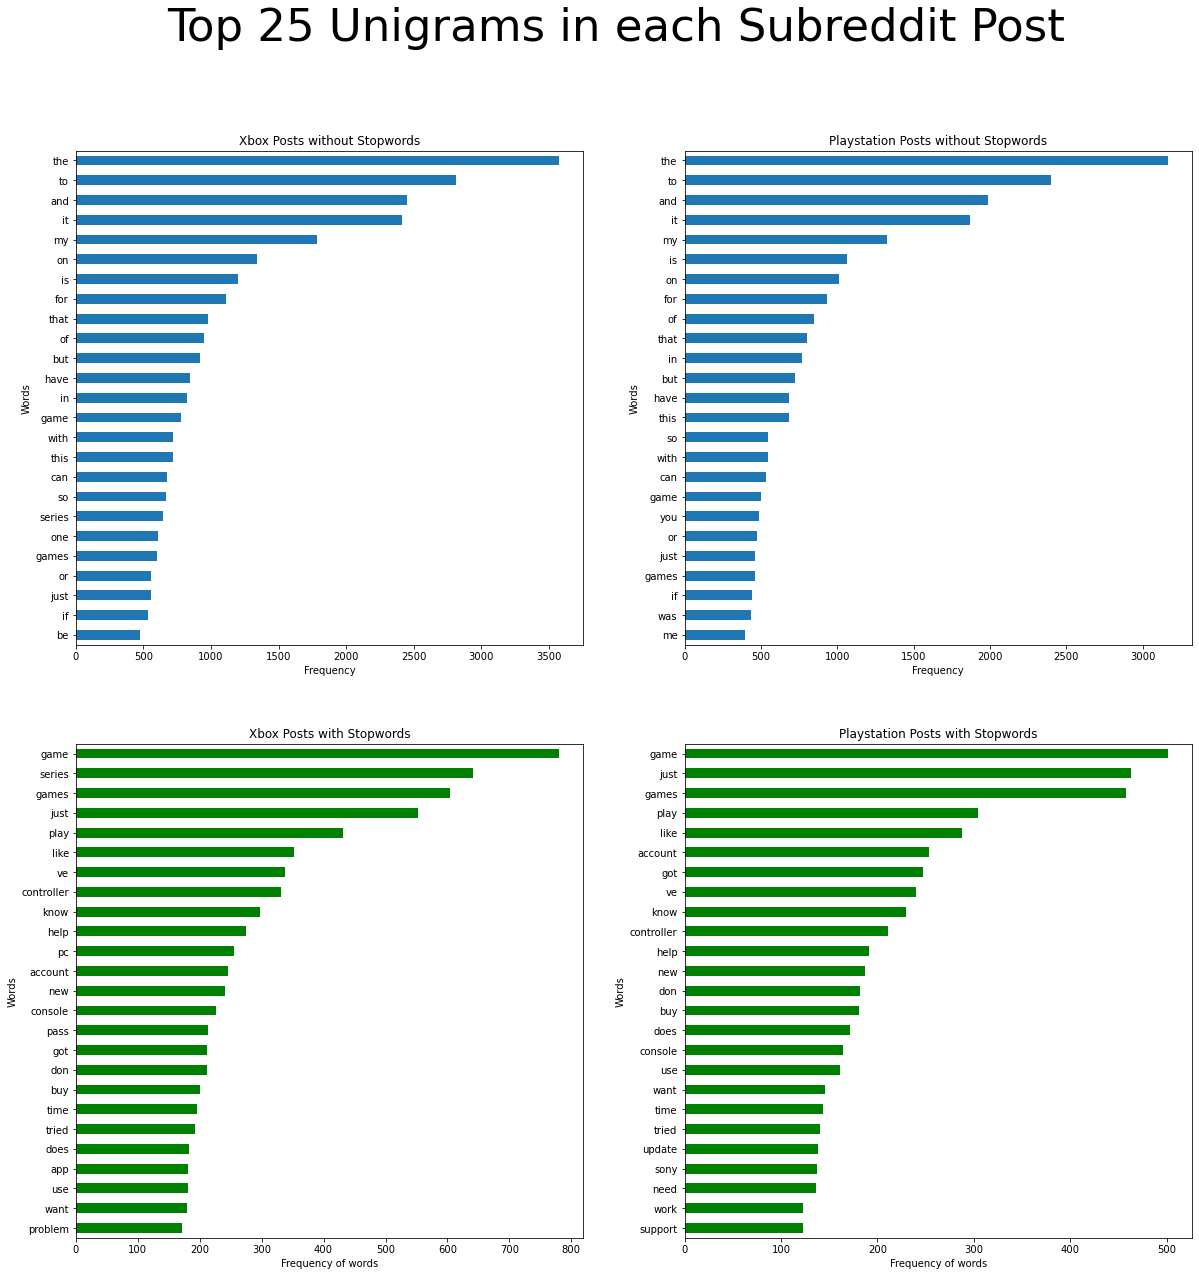

In [31]:
text_ngrams('unigram')

**Observation**

For the posts without the stopwords, the top words were mostly prepositions which we will ignore.
For the posts with stopwords, words like 'game, games, like, know, controller' are observed in both posts. We could remove them by including them into a stopword list, but I've decided to leave them in, to see the effects of how the Tf-idf balances out the term frequency when there are words that highly occur in both subreddits.

The frequency for the top 15 unigram was approximately 100 - 800 for the 2 subreddits

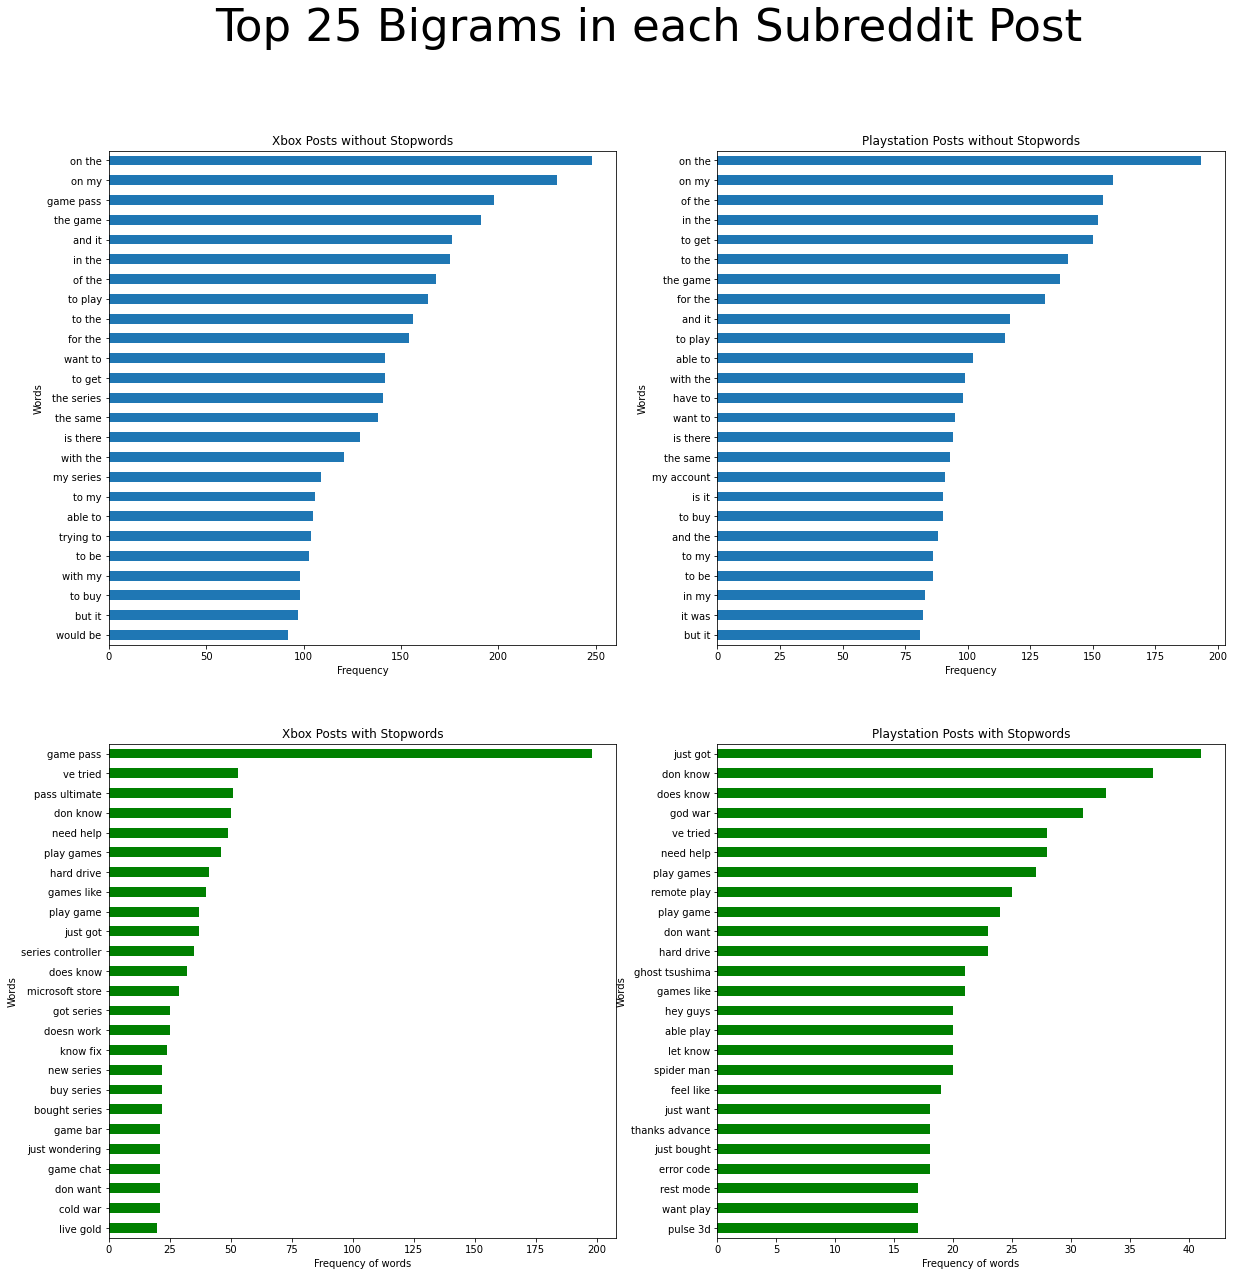

In [32]:
text_ngrams('bigram')

**Observations**

For posts without stopwords, there was a combination of prepositions and adverbs which had a high frequency. 

Interestingly, the bigram for xbox 'game pass' was identified to have the highest frequency under xbox. The game pass represents the xbox user account, so no surprises. On the other hand, the top bigram for playstation were related to their exclusive game titles (e.g. god of war, ghost tsushima)

The frequency for the top 15 bigram was bwetween 25 to 200, with only 'gamepass' exceeding 50 frequency of words.

The bigrams above definite puts a clear distinction between the subreddits, but I'm not sure how useful it will be when we vectorize the data due to the low frequency.

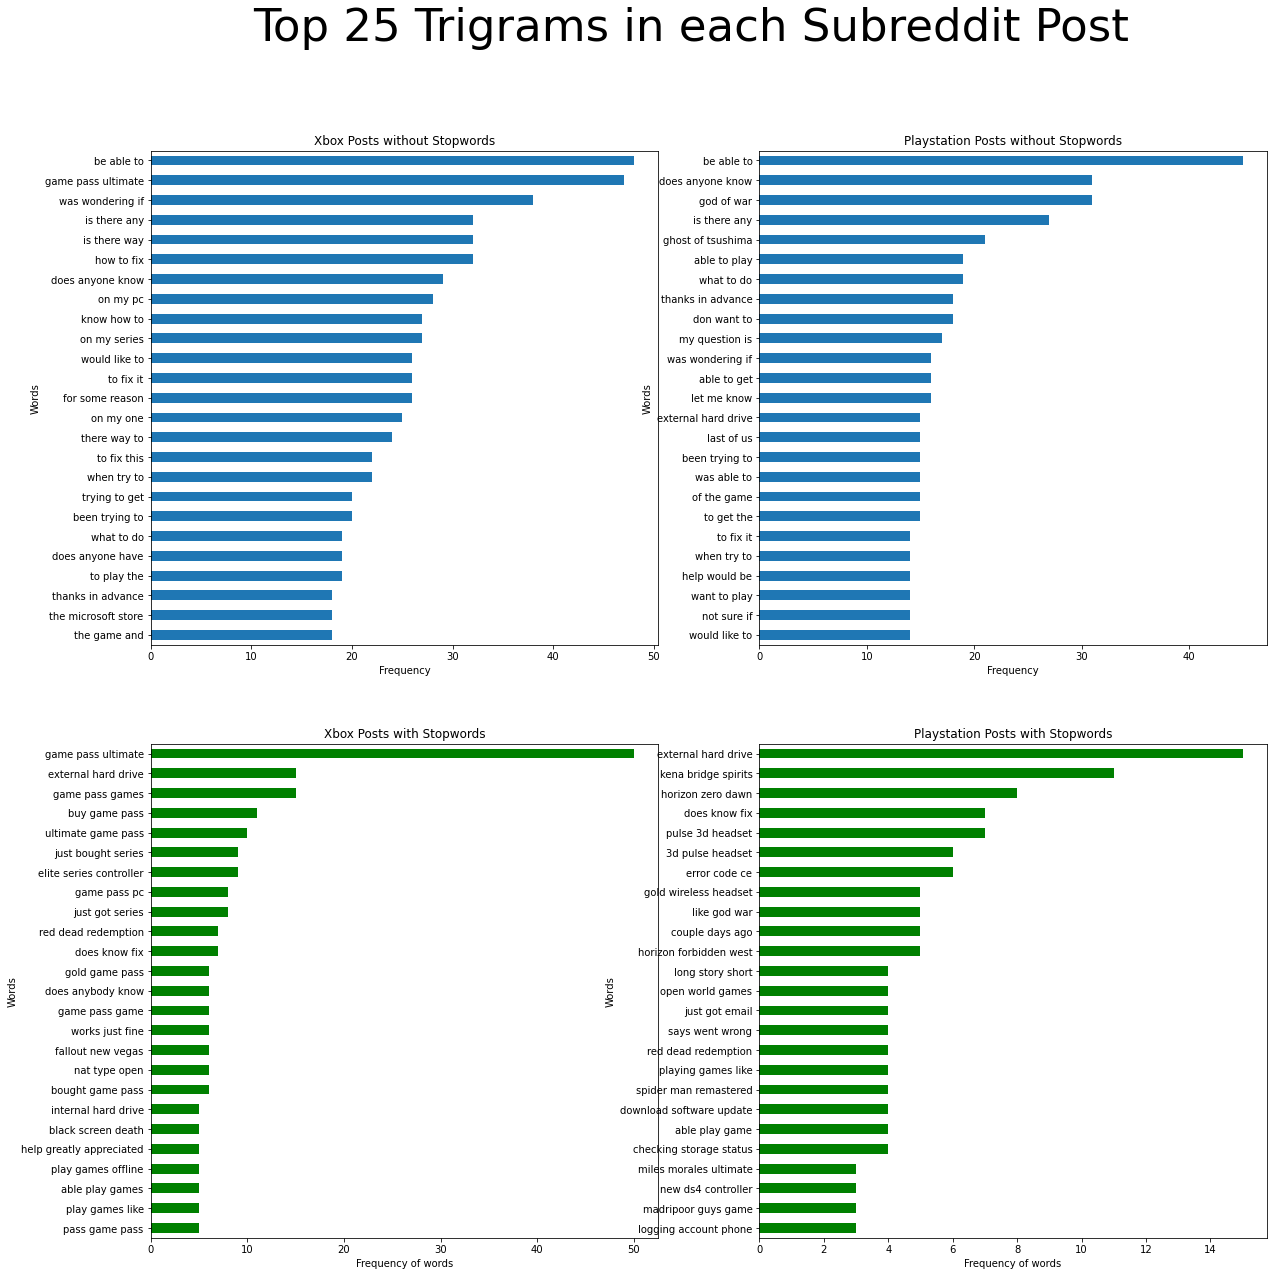

In [34]:
text_ngrams('trigram')

**Observations**

Interestingly, for both subreddits, their trigrams are very distinct towards the exclusive console games and common help questions. However, their frequency of words are far lesser than the uni and bigrams. Its improbable that the model will consider these features during vectorization, hence we will not include them into our grid search.

### Lemmatization

Part of feature engineering, Lemmatization reduces words showing an inflection in order to return a root word. We will be storing the lemmatized text into the dataframe to compare the results with the original text. 
first we'll tokenize the text, followed by transforming it, and joining the tokens back together to return a string.

In [ ]:
# Instantiate Lemmatizer & Tokenizer

def lemmatize(row):
    lemmatizer = nltk.WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    return [lemmatizer.lemmatize(r) for r in tokenizer.tokenize(row)]
    
posts['text_lemma'] = posts['text'].apply(lemmatize).str.join(' ')

### Stemming

Also part of feature engineering, Stemming is a method where the end of words are removed if it shows derivational changes to its root word. This could be helpful as most of the semantic meaning of a word is the root word. 

As such, stemming is strict compared to Lemmatization, but we'll like to compare the results by observing which text helps the model produce a better fit

In [ ]:
def stemming(row):
    # Instantiate Lemmatizer & Tokenizer
    stemming = nltk.PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    return [stemming.stem(r) for r in tokenizer.tokenize(row)]
    
posts['text_stemming'] = posts['text'].apply(stemming).str.join(' ')

In [ ]:
posts.loc[posts['text_lemma'] == posts['text_stemming'],]

**Obervations**
There are 3 posts observed where the lemmatized and stemming text are the same. This could be because they happen to transform to the same root words

## Read data to file 

We will prepare the data at this stage and read it to the file before model fitting. 
At this stage, we will binarize the subreddit whereby **Xbox = 1 & Playstation = 0**. This is important to note as this means we will be making predictions based on subreddit being Xbox(positive).


In [ ]:
# Binarize subreddit column
posts['subreddit'] = posts['subreddit'].map(lambda x:1 if x == 'xbox' else 0)

# Remove 'author' and rearrange columns
posts = posts[['text','text_lemma','text_stemming','subreddit']]

In [ ]:
# Write csv file to datasets
posts.to_csv('./datasets/final_posts.csv', index = False)